# Fit mrCOSTS to ICON data, all domain sizes

You must execute the fits before creating any of the published figures.

In [1]:
# netcdf/numpy/xray/stats
import numpy as np
import xarray as xr
import pandas as pd
import copy
import scipy
import glob

# OS interaction
import os
import sys

# import plotting
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.dates import DateFormatter
from pydmd.costs import COSTS
from pydmd.mrcosts import mrCOSTS
import string

import warnings

warnings.filterwarnings("ignore")

## Format plots

In [2]:
%matplotlib inline
# Higher resolution figures within the notebook
%config InlineBackend.figure_format = 'retina'

# Set the plot style from the seaborn library
sns.set_style("whitegrid")
context = "paper"
sns.set_context(context)

# Tol bright color scheme reordered to put my favorite colors first
tol_bright_reorder = [
    "#4477AA",
    "#CCBB44",
    "#EE6677",
    "#228833",
    "#66CCEE",
    "#AA3377",
    "#BBBBBB",
]
sns.set_palette(sns.color_palette(tol_bright_reorder))
alphabet = string.ascii_lowercase

# Data

Re-running this cell more than once will likely break the logic we are using here for setting up the directory structure.

In [3]:
dir_notebook = os.getcwd()
dir_data = os.path.join(dir_notebook, "data")
dir_print = os.path.join(dir_notebook, "figures/SI figures")
dir_results = os.path.join(dir_notebook, "mrCOSTS fit")

In [4]:
components = ["w", "u", "v"]
domain_list = ["1km", "500m", "250m", "125m", "lidar"]
domain_titles_dict = {
    "1km": "DX1000",
    "500m": "DX500",
    "250m": "DX250",
    "125m": "DX1215",
    "lidar": "lidar",
}

os.chdir(dir_data)
ds_data = {}
for domain in domain_list:
    ds_data[domain] = xr.open_dataset(f"{domain}.publication-version.nc").load()

ts = ds_data["lidar"].time
ts = ts - ts.isel(time=0)
ts = (ts / 1e9).values.astype(float)
# Time step in seconds
dt = 80

# Fit mrCOSTS

## Hyperparameters

The `limited` and `conjugate_pairs` kwargs require a version of mrCOSTS newer than March 2025.

In [6]:
# from lidar
window_lengths = np.array([10, 15, 30, 60, 120, 240, 480, 650])
step_sizes = np.array([2, 2, 3, 6, 12, 24, 48, 65])
svd_ranks = [6, 10, 10, 10, 10, 10, 10, 10]
num_decompositions = len(window_lengths)
global_svd_array = [False] * len(window_lengths)
pydmd_kwargs = {
    "eig_constraints": {"conjugate_pairs", "limited"},
    "real_eig_limit": 0.01,
    "varpro_flag": True,
}
costs_kwargs = None
strategy = "conj-pair"
num_frequency_bands = np.array(svd_ranks) // 2
relative_filter_length = 6
kern_method = "flat"

# Set this flag to `True` in order to execute the fits
fit = False

## Fit

In [7]:
if fit:
    for domain in domain_list:
        print("---------------------------")
        print(domain)

        # Organize the data to decompose
        data_long_name = "icon_crossinn_2019091400_{}.{}.var={}".format(
            domain, "80s-resample", "all-vel"
        )
        data_short_name = f"{domain}.all-vel"
        ds_obs = ds_data[domain]

        # Stack the three velocity components
        data = np.concatenate(
            (ds_obs["w"].T.values, ds_obs["u"].T.values, ds_obs["v"].T.values)
        )

        mrc = mrCOSTS(
            svd_rank_array=svd_ranks,
            window_length_array=window_lengths,
            step_size_array=step_sizes,
            global_svd_array=global_svd_array,
            transform_method="absolute",
            pydmd_kwargs=pydmd_kwargs,
            n_components_array=num_frequency_bands,
            kern_method=kern_method,
            relative_filter_length=relative_filter_length,
            costs_kwargs=costs_kwargs,
        )

        test = mrc.fit(data, ts)

        os.chdir(dir_results)
        filename = ".".join([data_long_name, strategy])
        file_list = glob.glob(filename + "*.nc")
        map(os.remove, file_list)
        mrc.to_netcdf(filename)
        print("---------------------------")
        print()

In [8]:
os.chdir(dir_results)
mrc_dict = {}

for domain in domain_list:
    data_long_name = "icon_crossinn_2019091400_{}.{}.var={}".format(
        domain, "80s-resample", "all-vel"
    )
    filename = ".".join([data_long_name, strategy])
    file_list = glob.glob(filename + "*.nc")
    mrc = mrCOSTS()
    mrc.from_netcdf(file_list)
    mrc_dict[domain] = mrc

# Initial evaluation of the fits

Use these plots to get a sense of how the mrCOSTS hyperparameters performed.

In [9]:
local_scale_separation_plots = False

if local_scale_separation_plots:

    for domain in domain_list:
        mrc = mrc_dict[domain]

        # Plot all decomposition levels
        for n_decomp in range(0, num_decompositions):
            mrd = mrc.costs_array[n_decomp]

            # The data for each decomposition level is built here to avoid
            # reconstructing the data for each plot. If this is not done theto say that it is
            # plots can still be rendered but will take slightly longer.
            if n_decomp == 0:
                ds_obs = ds_data[domain]

                # Stack the three velocity components
                data = np.concatenate(
                    (
                        ds_obs["w"].T.values,
                        ds_obs["u"].T.values,
                        ds_obs["v"].T.values
                    )
                )
                x_iter = data
            else:
                x_iter, _ = mrc.costs_array[n_decomp - 1].scale_separation(
                    scale_reconstruction_kwargs=mrc._costs_recon_kwargs
                )

            # for ncomp, comp in enumerate(components):
            for ncomp, comp in enumerate(["u"]):
                # Single points in space`
                # space_index = 6 + len(ds_obs["height"]) * ncomp
                space_index = 5 + len(ds_obs["height"]) * 1
                _, _ = mrc.plot_local_time_series(
                    space_index,
                    n_decomp,
                    x_iter,
                    scale_reconstruction_kwargs=mrc._costs_recon_kwargs,
                )

                plt.gcf().suptitle(
                    f"{domain}, window length={mrd.window_length}, {comp} component",
                    y=1,
                )

In [10]:
local_scale_separation_plots = False

if local_scale_separation_plots:
    for domain in domain_list:
        mrc = mrc_dict[domain]

        # Plot all decomposition levels
        for n_decomp in range(0, num_decompositions):
            mrd = mrc.costs_array[n_decomp]
            fig1, ax1 = mrd.plot_omega_histogram()
            fig1.suptitle(f"{domain}, window length={mrd.window_length}")

# Scale separation

In [16]:
score = False
if score:
    n_optimal_dict = {}
    for ndomain, domain in enumerate(domain_list):
        print("---------------------------")
        print(domain)

        n_components_range = np.arange(8, 24)
        scores, n_optimal = mrc_dict[domain].global_cluster_hyperparameter_sweep(
            n_components_range, transform_method="log10"
        )

        print("Optimal silhouette score is = {}".format(n_optimal))
        plt.figure(figsize=(5, 2.5))
        plt.plot(n_components_range, scores)
        plt.gca().set_xlabel("n_components (-)")
        plt.gca().set_title(f"ICON {domain}; {strategy}")
        plt.gca().set_ylabel("Silhouette Score (-)")

        n_optimal_dict[domain] = n_optimal

        print("---------------------------")
        print()
else:
    # Note I made some subjective decisions by choosing the largest
    # number of justifiable bands in order to best separate the
    # bands.
    n_optimal_dict = {
        "1km": 20,
        "500m": 15,
        "250m": 11,
        "125m": 23,
    }

    # Here are the objective results
    # n_optimal_dict = {
    #     "1km": 20,
    #     "500m": 9,
    #     "250m": 11,
    #     "125m": 23,
    # }

In [17]:
for ndomain, domain in enumerate(domain_list):

    mrc = mrc_dict[domain]

    cluster_centroids, omega_classes, omega_array = mrc.global_cluster_omega(
        n_optimal_dict[domain], transform_method="log10"
    )

# Global clustering

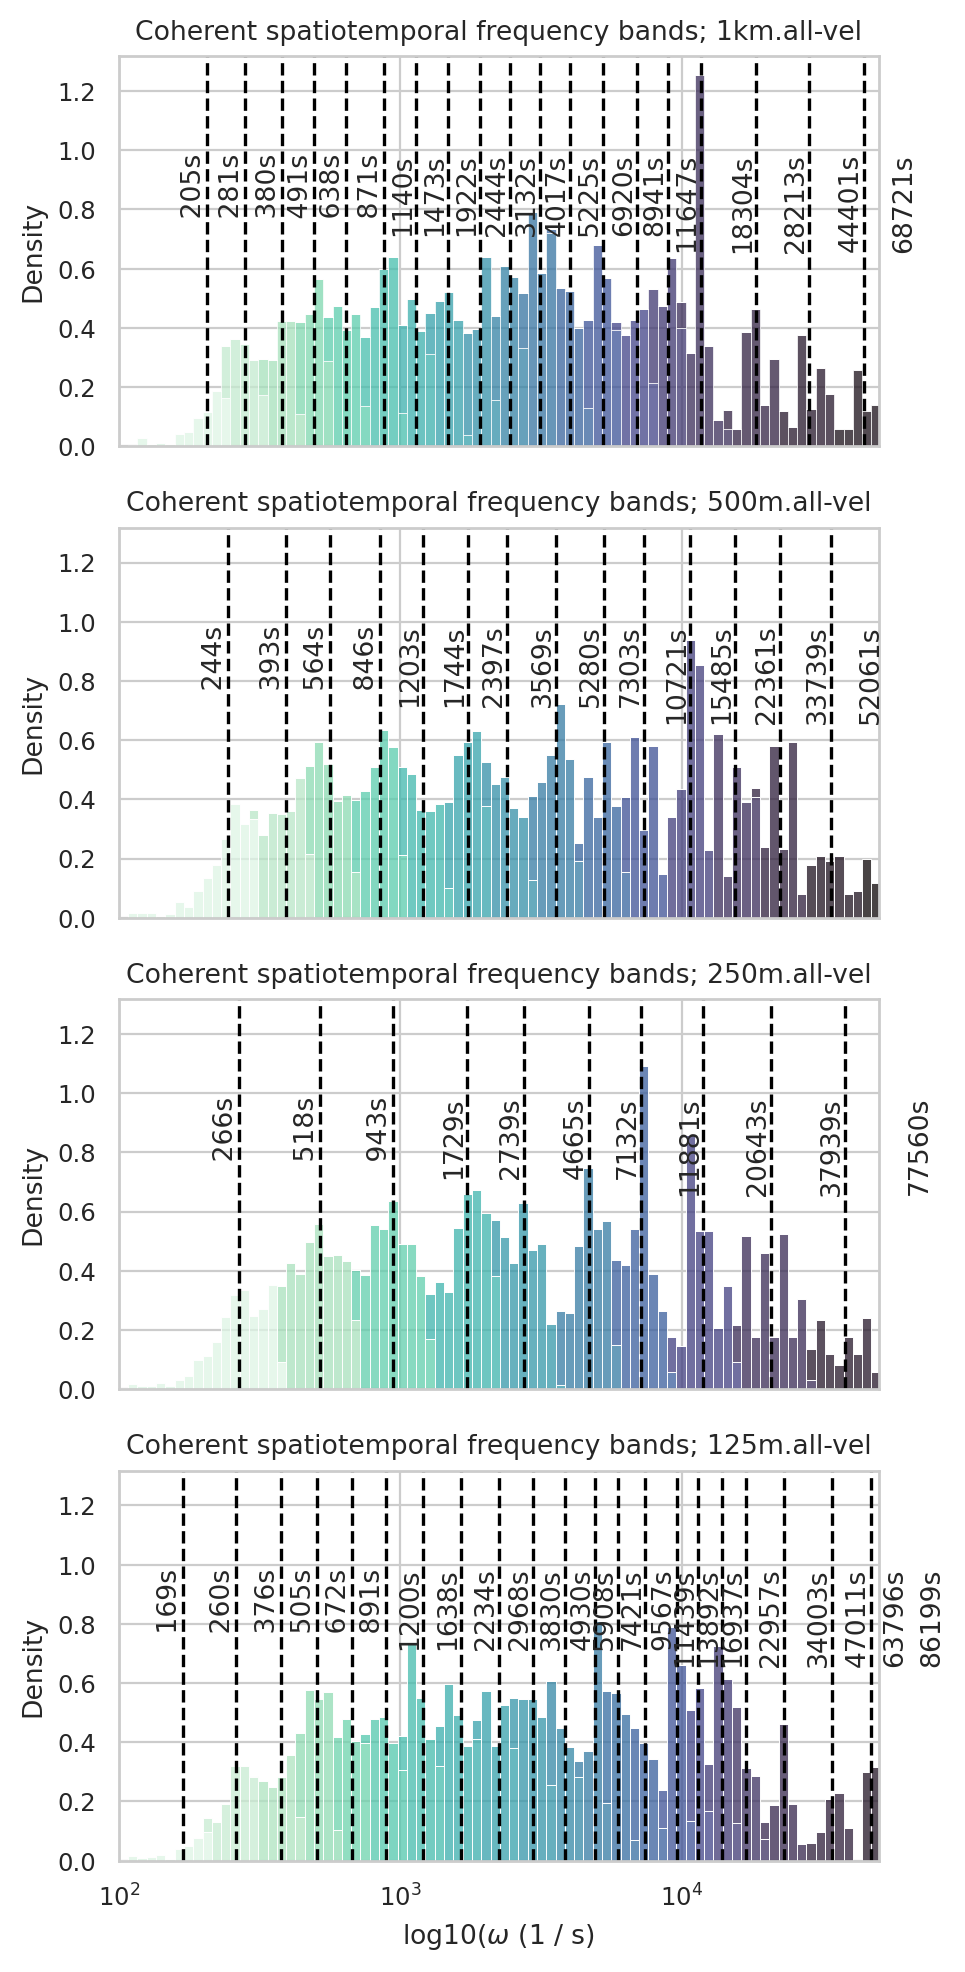

In [18]:
fig_clustering, axes_clustering = plt.subplots(
    4, 1, sharex=True, sharey=True, figsize=(5, 10)
)

for nd, domain in enumerate(domain_list):
    data_short_name = f"{domain}.all-vel"

    mrc = mrc_dict[domain]
    mrc.multi_res_interp()
    df = mrc._da_omega.to_dataframe()

    n_optimal = n_optimal_dict[domain]
    cluster_centroids, omega_classes, omega_array = mrc.global_cluster_omega(
        n_optimal, transform_method="log10"
    )

    ax = axes_clustering[nd]
    hue_order = np.arange(len(np.unique(omega_classes))).astype(str)
    sns.histplot(
        x=(2 * np.pi) / (10**omega_array),
        hue=omega_classes,
        hue_order=hue_order,
        common_bins=True,
        common_norm=True,
        stat="density",
        multiple="stack",
        bins=100,
        binrange=(2, 5.3),
        palette="mako",
        legend=False,
        ax=ax,
        log_scale=True,
    )
    ax.set_title("Coherent spatiotemporal frequency bands; {}".format(data_short_name))
    ax.set_xlabel(r"log10($\omega$ (1 / s)")
    [
        ax.axvline((2 * np.pi) / (10**c), color="k", ls="--")
        for nc, c in enumerate(cluster_centroids)
        if (np.pi * 2) / 10**c > 100
    ]
    ylim_bottom, ylim_top = ax.get_ylim()
    [
        ax.text(
            (2 * np.pi) / 10**c,
            ylim_top - (ylim_top - ylim_bottom) / 4,
            "{:4.0f}s".format((2 * np.pi) / (10 ** (c))),
            rotation="vertical",
            va="top",
            ha="right",
        )
        for c in cluster_centroids
        if (np.pi * 2) / 10**c > 100
    ]
    ax.set_xlim(10**2, 5 * 10**4)
fig_clustering.tight_layout()